## TMA4215 - Project #2 ## 
*01.11.2024*

*Group ID:*

In this project we will work with image generation and processing.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from typing import Callable, List
import matplotlib.image
import scipy.sparse as sp
from scipy.sparse import diags, kron
from PIL import Image

In [6]:
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)

#### Task 1: Generating artificial images

To start off we will generate artificial fractal images.

#### a)

We begin by defining a generic Newton interation function.

In [3]:
def my_newton(f: Callable, Df: Callable, x0: float, maxiter: int=100, tol: float=1e-6) -> float:
    '''
    Perform Newton method

    Parameters:
    - f: function
    - Df: derivative of function
    - x0: initial guess
    - maxiter: maximum iterations (default 100)
    - tol: tolerance for stopping criteria (default 1e-6)
    '''
    for _ in range(maxiter):
        x1 = x0 - f(x0) / Df(x0)
        if abs(x1 - x0) < tol:
            return x1
        x0 = x1
    return x0

#### b)

Now, we want to make a grid-based Newton function that uses `my_newton` as a helper function in order to run the Newton
iteration on a grid of possible starting values from the complex square

$$
\Omega = \left\{ x + iy \ \middle|\ -1 \leq x, y \leq 1 \right\},
$$

sampled equidistantly on n points (including the boundary).

In [4]:
def grid_newton(f: Callable, Df: Callable, n: int, maxiter: int=100) -> np.ndarray:
    '''
    Perform grid-based Newton method

    Uses my_newton as a helper function

    Parameters:
    - f: function
    - Df: derivative of function
    - n: The number of points along each axis of the grid. A grid of size `n x n` will be created.
    - maxiter: maximum iterations (default 100)

    '''
    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y
    A = np.zeros(Z.shape, dtype=complex)
    
    for i in range(n):
        for j in range(n):
            A[i, j] = my_newton(f, Df, Z[i, j], maxiter=maxiter)
    return A

#### c)

We want to solve the equation $z^3 = 1, z \in \mathbb{C}$. 

**Analytical solution:**

We are tasked with finding the cube roots of unity, i.e., the solutions to the equation:
$$
z^3 = 1.
$$

We can express $ 1 $ in polar form as:
$$
1 = e^{i \cdot 0} = e^{i \cdot 2k\pi}, \quad \text{for any integer } k.
$$

The general form of a complex number $ z $ is:
$$
z = r e^{i \theta},
$$
where $ r $ is the modulus and $ \theta $ is the argument (angle).

To solve $ z^3 = 1 $, we substitute $ z = r e^{i\theta} $ and get:
$$
r^3 e^{i 3\theta} = e^{i \cdot 2k\pi}.
$$

This gives two conditions:
1. $ r^3 = 1 \Rightarrow r = 1 $ (since $ r > 0 $),
2. $ 3\theta = 2k\pi \Rightarrow \theta = \frac{2k\pi}{3} $.

Thus, the solutions are:
$$
z_k = e^{i \frac{2k\pi}{3}}, \quad \text{for } k = 0, 1, 2.
$$

These give us the following roots:
$$
z_0 = e^{i \cdot 0} = 1,
$$
$$
z_1 = e^{i \cdot \frac{2\pi}{3}} = -\frac{1}{2} + i\frac{\sqrt{3}}{2},
$$
$$
z_2 = e^{i \cdot \frac{4\pi}{3}} = -\frac{1}{2} - i\frac{\sqrt{3}}{2}.
$$

To apply the `grid_newton` method, we need two things: the function and its derivative, as defined below.

In [5]:
def g(z):
    return z**3 - 1

def Dg(z):
    return 3 * z**2

We now define a function that creates a plot where each point $x \in \Omega$ is assigned a color based on the root (that we found analytically) to which the Newton iteration, starting from that point, converges.

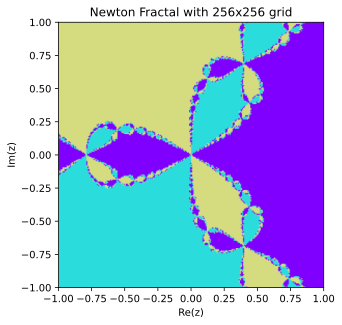

In [6]:
def plot_sol(f: Callable, Df: Callable, roots, n: int=256, maxiter: int=100):
    '''
    Plots the newton fractal for a given funciton and its derivative.

    Parameters:
    - f: function
    - Df: derivative of function
    - n: the resolution of the grid

    '''
    
    A = grid_newton(f, Df, n, maxiter=maxiter)
    
    # Create an empty array for the color plot
    img = np.zeros((n, n, 3))
    
    for i in range(n):
        for j in range(n):
            z = A[i, j]
            distances = [abs(z - root) for root in roots]
            closest_root = np.argmin(distances)
            img[i, j] = plt.get_cmap('rainbow')(closest_root / 3.0)[:3]  # Using a colormap
    
    plt.imshow(img, extent=(-1, 1, -1, 1))
    plt.title(f'Newton Fractal with {n}x{n} grid')
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.show()

# Run the plotting function
roots = [1, np.exp(2j * np.pi / 3), np.exp(4j * np.pi / 3)]
plot_sol(g, Dg, roots, n=256)

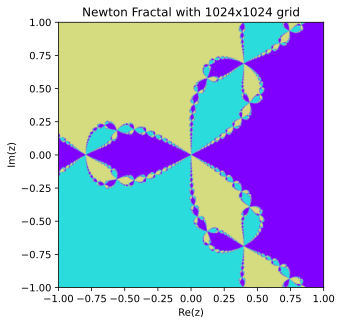

In [7]:
plot_sol(g, Dg, roots, n=1024)

Luckily we have a Macbook with the M3 chip, so we dare to do n=1024 aswell as n=256. For the much larger n-value we observe a much smoother image for the regions where the colors collide.

#### d)

We are now going to consider the equation $h(z) = z^{5} - 1$. Again, defining the function and its derivative.

In [8]:
def h(z):
    return z**5 - 1

def Dh(z):
    return 5*z**4

Now we get the roots and 

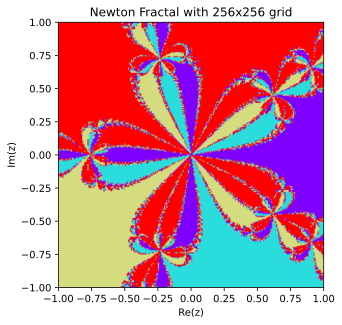

In [9]:
roots1 = [1, np.exp(2j * np.pi / 5), np.exp(4j * np.pi / 5), np.exp(6j * np.pi / 5), np.exp(8j * np.pi / 5)]
plot_sol(h, Dh, roots1, n=256)

In [10]:
def plot_angle(f: Callable, Df: Callable, n: int=256, maxiter: int=100) -> None:
    '''
    Plot the angle between the Newton iteration result at each grid point and the trivial solution

    Parameters:
    - f: function
    - Df: derivative of function
    - n: The number of points along each axis of the grid. A grid of size `n x n` will be created (default is 256)
    - maxiter: The maximum number of iterations for the Newton method (default is 100)
    '''

    z0 = 1
    A = grid_newton(f, Df, n, maxiter=maxiter)
    
    # Compute the angle between each grid point and the trivial solution
    angles = np.angle(A / z0)
    
    # Normalize the angles to the range [0, 1]
    norm_angles = (angles + np.pi) / (2 * np.pi)  # range [0, 1] since angles are in [-π, π]
    
    # Apply the colormap to the normalized angles
    cmap = plt.get_cmap('rainbow')
    img_colors = cmap(norm_angles)
    
    # Plot the colored image
    plt.imshow(img_colors, extent=(-1, 1, -1, 1))
    plt.title(f'Newton Fractal with {n}x{n} grid after {maxiter} iterations')
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.show()

Now we plot for $k=5$ and $k=15$ steps.

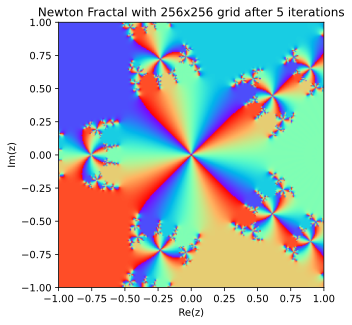

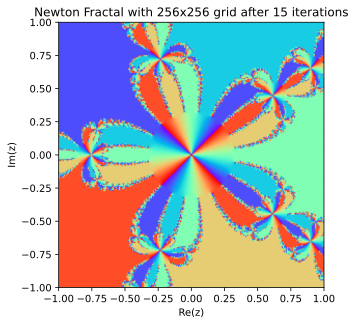

In [11]:
# Plotting for k = 5 iterations
plot_angle(h, Dh, n=256, maxiter=5)

# Plotting for k = 15 iterations
plot_angle(h, Dh, n=256, maxiter=15)


Here we define a function that creates a neat animation for visualizing the different plots, inline in the Jupyter-notebook, for $k=0,1,...,K$ steps.

In [12]:
def animate(k: int) -> List[matplotlib.image.AxesImage]:
    '''
    Update the plot for the given iteration step in the Newton method animation.
    '''

    A = grid_newton(h, Dh, n, maxiter=k)
    angles = np.angle(A / z0)
    
    # Normalize the angles to the range [0, 1]
    norm_angles = (angles + np.pi) / (2 * np.pi)
    
    # Apply colormap
    img_colors = cmap(norm_angles)
    img.set_array(img_colors)
    ax.set_title(f'Newton Fractal - Iteration {k}')
    return [img]


# Setup for animation
n = 256  # Grid resolution
K = 20  # Maximum number of frames/iterations
z0 = 1  # Reference solution to calculate the angle
cmap = plt.get_cmap('rainbow')  # Choose the colormap

# Initialize the figure
fig, ax = plt.subplots()
A_initial = grid_newton(g, Dg, n, maxiter=0)
angles_initial = np.angle(A_initial / z0)
norm_angles_initial = (angles_initial + np.pi) / (2 * np.pi)
img_colors_initial = cmap(norm_angles_initial)
img = ax.imshow(img_colors_initial, extent=(-1, 1, -1, 1))
ax.set_title('Newton Fractal - Iteration 0')
ax.set_xlabel('Re(z)')
ax.set_ylabel('Im(z)')

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=range(K + 1), blit=True)
plt.close() # ensuring no extra plot under the animation

# Display as an HTML5 video inline in the notebook
HTML(anim.to_jshtml())


#### Task 2: Bézier curves and shapes

Now, we will consider shapes in the plane using Bézier curves and Hermite interpolation.

The Bézier curve $\bf{b} : [0,1] \to \mathbb{R}^d$ is defined as
\begin{align*}
& \bf{b}_n(t; \bf{p}_0, ..., \bf{p}_n) = (1-t) \bf{b}_{n-1} (t; \bf{p}_0, ..., \bf{p}_{n-1}) + t\bf{b}_{n-1} (t; \bf{p}_1, ..., \bf{p}_n) \\
& \bf{b}_0(t;\bf{p}_0) = \bf{p}_0
\end{align*}

where $\bf{p}_0, ..., \bf{p}_n \in \mathbb{R}^d, n\in \mathbb{N}$ denote $n+1$ ordered points.

#### a)
Given a Bézier curve $\bf{c}(t) = \bf{b}_n(t; \bf{p}_0, ..., \bf{p}_n)$ we will prove that the following properties hold. 

**1) $\bf{c} (0) = \bf{p}_0$ and $\bf{c} (1) = \bf{p}_n$**

\begin{align*}
\bf{c}(0) & = \bf{b}_n \left(0; \bf{p}_0, ..., \bf{p}_n\right) \\
& = \left(1-0\right) \bf{b}_{n-1} \left(0; \bf{p}_0, ..., \bf{p}_{n-1}\right) + 0\bf{b}_{n-1} \left(0; \bf{p}_1, ..., \bf{p}_n\right) \\
& = \bf{b}_{n-1} \left(0; \bf{p}_0, ..., \bf{p}_{n-1}\right) \\
& = ... \\
& = \bf{b}_0 \left(0; \bf{p}_0\right) \\
& = \bf{p}_0
\end{align*}


\begin{align*}
\bf{c}(1) & = \bf{b}_n \left(1; \bf{p}_0, ..., \bf{p}_n\right) \\
& = \left(1-1\right) \bf{b}_{n-1} \left(1; \bf{p}_0, ..., \bf{p}_{n-1}\right) + 1\bf{b}_{n-1} \left(1; \bf{p}_1, ..., \bf{p}_n\right) \\
& = \bf{b}_{n-1} \left(1; \bf{p}_1, ..., \bf{p}_n\right) \\
& = ... \\
& = \bf{b}_0 \left(1; \bf{p}_n\right) \\
& = \bf{p}_n
\end{align*}

**2) $\bf{c}' (0) = n (\bf{p}_1 - \bf{p}_0)$ and $\bf{c}' (1) = n (\bf{p}_n -\bf{p}_{n-1})$**

First we compute the derivate of $\bf{c}_0$

\begin{align*}
\bf{c}'(t) & = \frac{d}{dt} ((1-t) \bf{b}_{n-1} (t; \bf{p}_0, ..., \bf{p}_{n-1}) + t\bf{b}_{n-1} (t; \bf{p}_1, ..., \bf{p}_n)) \\
& = - \bf{b}_{n-1} (t; \bf{p}_0, ..., \bf{p}_{n-1}) + (1-t) \frac{d}{dt} (\bf{b}_{n-1} (t; \bf{p}_0, ..., \bf{p}_{n-1})) + \bf{b}_{n-1} (t; \bf{p}_1, ..., \bf{p}_n) + t \frac{d}{dt} (\bf{b}_{n-1} (t; \bf{p}_1, ..., \bf{p}_n))
\end{align*}

Now we evaluate the derivative at $t=0$ and $t=1$

\begin{align*}
\bf{c}'(0) & = - \bf{b}_{n-1} (0; \bf{p}_0, ..., \bf{p}_{n-1}) + (1-0) \frac{d}{dt} (\bf{b}_{n-1} (0; \bf{p}_0, ..., \bf{p}_{n-1})) + \bf{b}_{n-1} (0; \bf{p}_1, ..., \bf{p}_n) + 0 \frac{d}{dt} (\bf{b}_{n-1} (t; \bf{p}_1, ..., \bf{p}_n)) \\
& = - \bf{b}_{n-1} (0; \bf{p}_0, ..., \bf{p}_{n-1}) + \bf{b}_{n-1} (0; \bf{p}_1, ..., \bf{p}_n) 
\end{align*}

From 1) we know that $\bf{b}_{n-1} (0; \bf{p}_0, ..., \bf{p}_{n-1}) = \bf{p_0}$. We have to look at $\bf{b}_{n-1} (0; \bf{p}_1, ..., \bf{p}_n)$.

\begin{align*}
\bf{b}_{n-1} (0; \bf{p}_1, ..., \bf{p}_n) & = (1-0) \bf{b}_{n-2} (0; \bf{p}_1, ..., \bf{p}_{n-1}) + 0 \bf{b}_{n-2} (0; \bf{p}_2, ..., \bf{p}_n) \\
& = \bf{b}_{n-2} (0; \bf{p}_1, ..., \bf{p}_{n-1}) \\
& = ... \\
& = \bf{b}_0 (0; \bf{p}_1) \\
& = \bf{p}_1
\end{align*}

Moreover, the derivative of a Bézier curve is scaled by the degree of the Bézier curve we´re differentiating. This comes from the fact that $\bf{p}_{i,n}$ are polynomials (specifically the Bernstein polynomials), and it is known that differentiating a polynomial of degree n always indroduces a factor of n.
Thus, 
\begin{align*}
\bf{c}'(0)  = n(\bf{p}_1 - \bf{p}_0)
\end{align*}

Furthermore, 

\begin{align*}
\bf{c}'(1) & = - \bf{b}_{n-1} (1; \bf{p}_0, ..., \bf{p}_{n-1}) + (1-1) \frac{d}{dt} (\bf{b}_{n-1} (1; \bf{p}_0, ..., \bf{p}_{n-1})) + \bf{b}_{n-1} (1; \bf{p}_1, ..., \bf{p}_n) + 1 \frac{d}{dt} (\bf{b}_{n-1} (t; \bf{p}_1, ..., \bf{p}_n)) \\
& = - \bf{b}_{n-1} (1; \bf{p}_0, ..., \bf{p}_{n-1}) + \bf{b}_{n-1} (1; \bf{p}_1, ..., \bf{p}_n) 
\end{align*}

From 1) we know that $\bf{b}_{n-1} (1; \bf{p}_1, ..., \bf{p}_n) = \bf{p}_n$. We have to look at $\bf{b}_{n-1} (1; \bf{p}_0, ..., \bf{p}_{n-1})$.

\begin{align*}
\bf{b}_{n-1} (1; \bf{p}_0, ..., \bf{p}_{n-1}) & = (1-1) \bf{b}_{n-2} (1; \bf{p}_0, ..., \bf{p}_{n-2}) + 1 \bf{b}_{n-2} (1; \bf{p}_1, ..., \bf{p}_{n-1}) \\
& = \bf{b}_{n-2} (1; \bf{p}_1, ..., \bf{p}_{n-1}) \\
& = ... \\
& = \bf{b}_0 (1; \bf{p}_{n-1}) \\
& = \bf{p}_{n-1}
\end{align*}

Thus 
\begin{align*}
\bf{c}'(1)  = n(\bf{p}_n - \bf{p}_{n-1})
\end{align*}

**3) $\bf{c}'' (0) = n (n-1) (\bf{p}_0 - 2\bf{p}_1 + \bf{p}_2)$ and $\bf{c}'' (1) = n (n-1) (\bf{p}_n - 2\bf{p}_{n-1} + \bf{p}_{n-2})$ for $n \geq 2$**

To compute the second derivative $c''(t)$, we differentiate the Bézier curve recursively. Note that $n \geq 2$ is required because the second derivative involves at least three control points ($p_0$, $p_1$, and $p_2$), and without three points, there wouldn't be sufficient information to calculate curvature.

We start with the recursive definition of $c'(t)$:
$$
c'(t) = -b_{n-1}(t; p_0, \dots, p_{n-1}) + (1 - t) \frac{d}{dt} b_{n-1}(t; p_0, \dots, p_{n-1}) + b_{n-1}(t; p_1, \dots, p_n) + t \frac{d}{dt} b_{n-1}(t; p_1, \dots, p_n)
$$

Now, we differentiate this expression again to obtain $c''(t)$:
$$
c''(t) = \frac{d}{dt} \left( -b_{n-1}(t; p_0, \dots, p_{n-1}) + b_{n-1}(t; p_1, \dots, p_n) \right)
$$
Applying the product rule:
$$
c''(t) = \frac{d}{dt} \left( -b_{n-1}(t; p_0, \dots, p_{n-1}) \right) + \frac{d}{dt} \left( b_{n-1}(t; p_1, \dots, p_n) \right)
$$
Simplifying further by differentiating each term:
$$
c''(t) = b_{n-2}(t; p_0, \dots, p_{n-2}) - 2b_{n-2}(t; p_1, \dots, p_{n-1}) + b_{n-2}(t; p_2, \dots, p_n)
$$

Now, let's evaluate $c''(t)$ at $t = 0$ and $t = 1$:

- At $t = 0$:
$$
c''(0) = n(n - 1)\left(p_0 - 2p_1 + p_2\right)
$$
This result comes from the fact that the second derivative involves the difference of the control points scaled by the binomial coefficients. The factor $n(n - 1)$ arises due to the second differentiation of the polynomial.

- At $t = 1$:
$$
c''(1) = n(n - 1)\left(p_n - 2p_{n-1} + p_{n-2}\right)
$$
Similarly, this result is derived by evaluating the second derivative at $t = 1$, with control points shifting to the last points in the list.

Thus, the second derivatives at $t = 0$ and $t = 1$ are:
$$
c''(0) = n(n - 1)(p_0 - 2p_1 + p_2)
$$
$$
c''(1) = n(n - 1)(p_n - 2p_{n-1} + p_{n-2})
$$

which holds for $n \geq 2$.


$\square$

#### b)

In [13]:


def de_Casteljau(P, t):
    """
    Implements the de Casteljau algorithm to compute a Bézier curve.
    
    Parameters:
        P (list of tuples): Control points as a list of 2D points (x, y).
        t (float): The parameter t in [0, 1].
    
    Returns:
        tuple: The final Bézier point at parameter t and all intermediate points at each level.
    """
    n = len(P) - 1  # Degree of the Bézier curve
    Pvecs = [P]  # To store points at each level
    
    # Convert P to a numpy array for easier manipulation
    P = np.array(P)
    
    # Iteratively apply de Casteljau's algorithm
    for k in range(1, n+1):
        new_points = (1 - t) * P[:-1] + t * P[1:]  # Compute intermediate points
        Pvecs.append(new_points)  # Store them
        P = new_points  # Update the control points for the next iteration
    
    return P[0], Pvecs

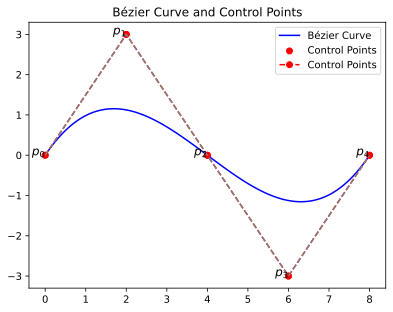

In [23]:
P = np.array([
    [0,0], 
    [2,3], 
    [4,0], 
    [6, -3], 
    [8,0]
])

# Generate Bézier curve points
t_values = np.linspace(0, 1, 100)
curve = np.array([de_Casteljau(P, t)[0] for t in t_values])

# Plotting
plt.plot(curve[:, 0], curve[:, 1], label="Bézier Curve", color='blue')

# Plot control points
P_array = np.array(P)
plt.scatter(P_array[:, 0], P_array[:, 1], color='red', label="Control Points")
plt.plot(P[:, 0], P[:, 1], 'ro--', label='Control Points')
for i, (x, y) in enumerate(P):
    plt.text(x, y, f'$p_{i}$', fontsize=12, ha='right')

# Connect control points
plt.plot(P_array[:, 0], P_array[:, 1], '--', color='gray')

plt.title("Bézier Curve and Control Points")
plt.legend()
plt.show()


#### c)

1)

To ensure the composite curve $s(t)$ is continuous ($k = 0$) at $t = 1$, we require the following condition:

$$
\lim_{t \to 1^-} c(t) = \lim_{t \to 1^+} d(t - 1)
$$

This simplifies to:

$$
c(1) = d(0)
$$

Thus, for continuity, the last point of the curve $c(t)$, which is $c(1)$, must coincide with the first point of the curve $d(t)$, which is $d(0)$.

2)

For $s(t)$ to be continuously differentiable ($k = 1$) at $t = 1$, we require that the first derivatives of $c(t)$ and $d(t - 1)$ match at $t = 1$. This can be written as:

$$
\lim_{t \to 1^-} \frac{d}{dt}c(t) = \lim_{t \to 1^+} \frac{d}{dt}d(t - 1)
$$

By applying the chain rule to the right-hand side:

$$
\frac{d}{dt}d(t - 1) = \frac{d}{du}d(u) \cdot \frac{d}{dt}(t - 1) = \frac{d}{du}d(u)
$$

where $u = t - 1$. Thus, the condition for continuous differentiability simplifies to:

$$
\frac{d}{dt}c(1) = \frac{d}{du}d(0)
$$

Therefore, for continuous differentiability, the tangent vector at the end of $c(t)$ must equal the tangent vector at the beginning of $d(t)$.

3)

To satisfy $s \in C^1$, we need both continuity and continuous differentiability. 

We are given that $n = 3$, and the points $\mathbf{d}_0$, $\mathbf{d}_1$, and $\mathbf{d}_2$ are interpolated by the piecewise Bézier curve $s(t)$. 

#### Conditions for Interpolation:

The curve must pass through the given points $\mathbf{d}_0$, $\mathbf{d}_1$, and $\mathbf{d}_2$:
$$
s(0) = \mathbf{d}_0, \quad s(1) = \mathbf{d}_1, \quad s(2) = \mathbf{d}_2
$$
This gives us 3 conditions.

#### Continuity at $t = 1$:
To ensure continuity at $t = 1$, we must have:
$$
c(1) = d(0)
$$
where $c(t)$ and $d(t-1)$ represent the two Bézier curves for $t \in [0,1]$ and $t \in [1,2]$ respectively.

#### Continuous Differentiability at $t = 1$:
For continuous differentiability, the derivatives at $t = 1$ must also match:
$$
\frac{d}{dt}c(1) = \frac{d}{dt}d(0)
$$
Thus, the tangent vectors at the connecting point must be equal.

#### Degrees of Freedom:
Each Bézier curve has 4 control points in $\mathbb{R}^d$ since $n = 3$. Hence, we have 8 total control points, $\mathbf{p}_0, \mathbf{p}_1, \mathbf{p}_2, \mathbf{p}_3$ for the first curve $c(t)$ and $\mathbf{q}_0, \mathbf{q}_1, \mathbf{q}_2, \mathbf{q}_3$ for the second curve $d(t-1)$.

However, due to the conditions imposed:

- The interpolation conditions $s(0) = \mathbf{d}_0$, $s(1) = \mathbf{d}_1$, and $s(2) = \mathbf{d}_2$ fix 3 of the control points.
- The continuity condition at $t = 1$ fixes another point.
- The continuous differentiability condition at $t = 1$ fixes one more.

Thus, we have used 5 degrees of freedom, leaving us with:
$$
8 - 5 = 3 \quad \text{degrees of freedom}.
$$

Meaning we can choose 3 of the control points freely.

4)

To have a $C^1$ function $s(t)$ that is periodic, i.e., $s(0) = s(2)$, we need to add the two following conditions:

- **Continuity Condition:**
$$
s(0) = s(2)
$$
This means that the endpoints of the curve must coincide.

- **Continuous Differentiability:**
$$
\frac{d}{dt}s(0) = \frac{d}{dt}s(2)
$$
This ensures that the derivatives at $t = 0$ and $t = 2$ match, meaning the tangent vectors at both endpoints must be equal.

Thus, the additional condition for periodicity in $C^1$ is that both the function and its derivative must be equal at $t = 0$ and $t = 2$.

#### d)
Given a number $m$ of segements and $4m$ points $\bf{p}_{0,i}, \bf{p}_{1,i}, \bf{p}_{2,i}, \bf{p}_{3,i}\in \mathbb{R}^d$ for $ i = 1, ..., m$, the *periodic composite Bézier curve* $\mathbb{B} : [0,m] \to \mathbb{R}^d$ is defined by

$$ \bf{B}(t) = b_3 (t-i+1; \bf{p}_{0,i}, \bf{p}_{1,i}, \bf{p}_{2,i}, \bf{p}_{3,i}) \text{ for } i-1 \leq t < i \text{ and each } i = 1, ..., m$$ 

which further is periodic, i.e $\bf{B}(0) = \bf{B}(m)$.

We will now implement a function **composite_Bezier(P,t)** that evaluates $\bf{B}(t), t \in [0,m]$, where $P= (\bf{p}_{i,j})_{j=0, i=1}^{3,m}$ denotes a matrix of control points.

In [4]:
def composite_Bezier(P,t):
    """ 
    Evaluate the periodic composite Bézier curve B(t) for t in [0, m]

    Input: 
    - P = matrix of control points
    - t = parameter in [0, m] indicating the point to evaluate

    Output:
    - b3 = the evaluated point B(t) on the composite Bézier curve
    """

    m = P.shape[1]
    t = t % m 

    local_t = t - int(t)    

    p0 = P[int(t),0]
    p1 = P[int(t),1]
    p2 = P[int(t),2]
    p3 = P[int(t),3]


    b3 = (1-local_t)**3 * p0 + 3*(1-local_t)**2 * local_t * p1 + 3*(1-local_t) * local_t**2 * p2 + local_t**3 * p3

    return b3

In [5]:
import numpy as np
# 3-segment cubic composite B spline 
P = np.array([[(-1,0), (-1,1/3), (-1/3, 1), (0,1)],
              [(0,1), (1/3,1), (1,1/3), (0,1)],
              [(1,0), (1, -1/3), (1/3, -1), (0,-1)]
            ])

print(composite_Bezier(P, 1))

[0. 1.]


#### e)

In [6]:

def interpolate_periodic(A, V):
    '''
    Computes the control points for a periodic composite cubic Bézier curve.
    
    Parameters:
        A (list of tuples): Interpolation points a_0, ..., a_{m-1}.
        V (list of tuples): Velocities v_0, ..., v_{m-1}.
        
    Returns:
        np.array: A matrix of control points for the composite Bézier curve.
                  Each row contains the control points [P0, P1, P2, P3] for a segment.
    '''
    m = len(A)
    dim = len(A[0])  # Dimensionality of points (e.g., 2 for 2D)
    
    # Initialize matrix to store control points
    control_points_matrix = np.zeros((m, 4, dim))  # m segments, 4 control points, d dimensions

    # Loop through each point and compute control points for each Bézier segment
    for i in range(m):
        a_i = np.array(A[i])
        v_i = np.array(V[i])
        a_next = np.array(A[(i + 1) % m])  # Periodic: a_m = a_0
        v_next = np.array(V[(i + 1) % m])  # Periodic: v_m = v_0
        
        # Compute the two intermediate control points for the Bézier curve
        P1 = a_i + v_i / 3
        P2 = a_next - v_next / 3
        
        # Store the control points: P0 (start), P1, P2, P3 (end)
        control_points_matrix[i] = [a_i, P1, P2, a_next]
    
    return control_points_matrix


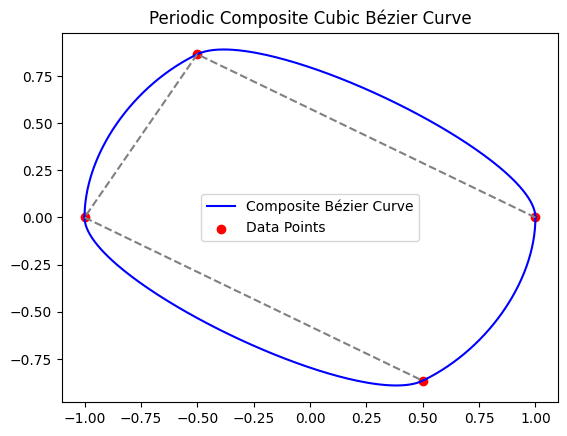

In [9]:

A = [
    (1.0, 0.0),   
    (-0.5, 0.866),
    (-1.0, 0.0),  
    (0.5, -0.866) 
]

V = [
    (0.0, 1.0),   
    (-0.866, -0.5),
    (0.0, -1.0),   
    (0.866, 0.5)   
]


# Generate the control points matrix
P = interpolate_periodic(A, V)

# Generate points on the Bézier curve
t_values = np.linspace(0, len(A), 500)  # 500 points on the curve
curve_points = np.array([composite_Bezier(P, t) for t in t_values])

# Plot the Bézier curve
plt.plot(curve_points[:, 0], curve_points[:, 1], label="Composite Bézier Curve", color='blue')

# Plot the control points
A_array = np.array(A)
plt.scatter(A_array[:, 0], A_array[:, 1], color='red', label="Data Points")

# Connect the data points
plt.plot(A_array[:, 0], A_array[:, 1], '--', color='gray')

# Label the axes and show the plot
plt.title("Periodic Composite Cubic Bézier Curve" )
plt.legend()
plt.show()


#### f)

#### g)

#### Task 3: Seamless cloning

Now we want to smoothly embed one image into another, using seamless cloning.

Color images consist of red, green, and blue channels at each pixel, which we represent as an $ m+2 $-by-$ n+2 $ image. This image is modeled as a function $ G $ from a domain $ \Omega $ to $ \mathbb{R}^3 $, where $ \Omega = [0, \dots, m+1] \times [0, \dots, n+1] \subset \mathbb{Z}^2 $. In the following, we work with each of the three color channels separately, meaning that we treat $ g : \Omega \to \mathbb{R} $ for each channel. Rather than interpreting the image simply as a function on a grid, we can think of the matrix $ g(\Omega) $ as belonging to $ \mathbb{R}^{(m+2) \times (n+2)} $. We split this image into two parts: the "inner" part $ g(\overset{\circ}{\Omega}) $, which belongs to $ \mathbb{R}^{m \times n} $, and the boundary $ g(\partial \Omega) $, which contains $ 2m + 2n + 4 $ pixels. This gives us $ \Omega = \overset{\circ}{\Omega} \cup \partial \Omega $.

Given an image $ F: \Psi \to \mathbb{R}^3 $, where $ \Psi \subset \mathbb{Z}^2 $, we aim to incorporate each $ g $ into the respective color channel $ f $ such that $ f_{\text{new}} = g + h $ on $ \Omega $, where $ h $ is a correction function designed to ensure the boundary appears smooth.


#### a)

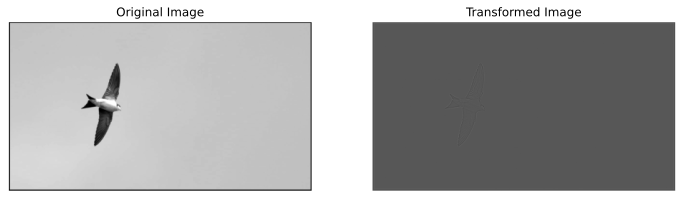

In [7]:
# Generate the sparse tridiagonal matrix Cm
def generate_tridiagonal_matrix(m):
    main_diag = 2 * np.ones(m)
    off_diag = -1 * np.ones(m - 1)
    Cm = diags([main_diag, off_diag, off_diag], [0, -1, 1], format='csr')
    return Cm

# Construct Δ_D
def construct_laplacian_operator(m, n):
    Cm = generate_tridiagonal_matrix(m)
    Cn = generate_tridiagonal_matrix(n)
    Im = sp.eye(m)
    In = sp.eye(n)
    Δ_D = kron(Cn, Im) + kron(In, Cm)
    return Δ_D

# Load and vectorize the image
def load_and_vectorize_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_data = np.asarray(img)
    m, n = img_data.shape
    f = img_data.flatten(order='F')  # Vectorize the image
    return f, m, n, img_data

# Apply Δ_D to the vectorized image and plot results
def apply_operator_and_plot(f, m, n, Δ_D, original_image):
    f_transformed = Δ_D.dot(f)  # Apply Δ_D to vectorized image
    f_transformed = f_transformed.reshape((m, n), order='F')  # Reshape to image dimensions
    
    # Plot the original and transformed images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(f_transformed, cmap='gray')
    ax[1].set_title("Transformed Image")
    ax[1].axis('off')
    
    plt.show()

image_path = 'data/bird.jpg'

# Load the image
f, m, n, original_image = load_and_vectorize_image(image_path)

# Generate Δ_D
Δ_D = construct_laplacian_operator(m, n)

# Apply Δ_D and plot the results
apply_operator_and_plot(f, m, n, Δ_D, original_image)

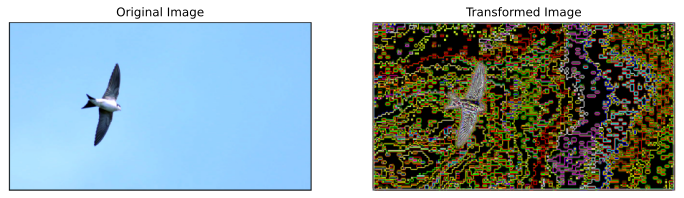

In [54]:
from PIL import Image
import numpy as np
import scipy.sparse as sp
from scipy.sparse import diags, kron
import matplotlib.pyplot as plt

# Generate the sparse tridiagonal matrix Cm
def generate_tridiagonal_matrix(m, val):
    main_diag = val * np.ones(m)
    off_diag = -1 * np.ones(m - 1)
    Cm = diags([main_diag, off_diag, off_diag], [0, -1, 1], format='csr')
    return Cm

# Construct Δ_D
def construct_laplacian_operator(m, n, val):
    Cm = generate_tridiagonal_matrix(m, val)
    Cn = generate_tridiagonal_matrix(n, val)
    In = sp.eye(n)
    Im = sp.eye(m)
    Δ_D = kron(Cn, Im) + kron(In, Cm)
    return Δ_D

# Load and vectorize the image
def load_and_vectorize_image(image_path):
    img = Image.open(image_path)
    img_data = np.asarray(img)
    
    m, n, c = img_data.shape  # m = height, n = width, c = 3 for RGB
    f = img_data.reshape(-1, order='F')  # Flatten the image for processing
    return f, m, n, c, img_data  # Return channel count as 3 for RGB

# Apply Δ_D to the vectorized image and plot results
def apply_operator_and_plot(f, m, n, c, Δ_D, original_image):
    # If the image is grayscale (c == 1), apply the operator directly

    f_transformed = np.zeros_like(f)
    
    # Apply the Laplacian operator to each color channel separately
    for channel in range(c):  # Assuming c=3 for RGB
        channel_f = f[channel::c]  # Extract the channel values
        f_transformed_channel = Δ_D.dot(channel_f)  # Apply Δ_D to the channel
        f_transformed[channel::c] = f_transformed_channel
    
    f_transformed = f_transformed.reshape((m, n, c), order='F')  # Reshape to original RGB shape
    
    # Plot the original and transformed images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(np.clip(f_transformed, 0, 255).astype(np.uint8))  # Clip to valid range and cast to int
    ax[1].set_title("Transformed Image")
    ax[1].axis('off')
    
    plt.show()

# Example image path
image_path = 'data/bird.jpg'

# Load the image
f, m, n, c, original_image = load_and_vectorize_image(image_path)

# Generate Δ_D
Δ_D = construct_laplacian_operator(m, n, 2)

# Apply Δ_D and plot the results
apply_operator_and_plot(f, m, n, c, Δ_D, original_image)

#### b)

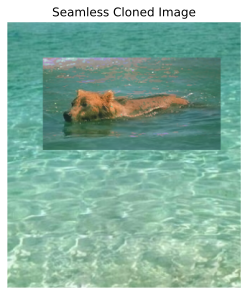

In [61]:
import scipy.sparse.linalg as spla
from scipy.sparse import diags, kron, eye

# Function to perform seamless cloning for color images
def seamless_cloning_color(image_F, image_G, pos_F, pos_G, patch_size):
    m, n = patch_size
    
    # Make a writable copy of image_F
    image_F_writable = np.copy(image_F)
    
    # Extract the region of interest from image_G (source) and image_F (target)
    patch_G = image_G[pos_G[0]:pos_G[0]+m, pos_G[1]:pos_G[1]+n, :]
    patch_F = image_F_writable[pos_F[0]:pos_F[0]+m, pos_F[1]:pos_F[1]+n, :]
    
    # Generate Δ_D (same for all channels)
    Δ_D = construct_laplacian_operator(m, n, 4)
    
    # Initialize a result patch for the cloned result
    patch_cloned = np.zeros_like(patch_G)
    
    # Apply seamless cloning channel by channel (R, G, B)
    for channel in range(3):  # For RGB images
        boundary_values = patch_F[:, :, channel] - patch_G[:, :, channel]
        b = boundary_values.flatten()
        
        # Solve Δ_D h = b with an iterative solver (Conjugate Gradient)
        h, info = spla.cg(Δ_D, b)
        if info != 0:
            print(f"Solver did not converge, info: {info}")
        
        # Reshape h back to the patch size
        h = h.reshape((m, n))
        
        # Compute the final cloned patch for the current channel: f_new = g + h
        patch_cloned[:, :, channel] = patch_G[:, :, channel] + h
    
    # Insert the cloned patch back into the writable copy of the original image
    image_F_writable[pos_F[0]:pos_F[0]+m, pos_F[1]:pos_F[1]+n, :] = patch_cloned
    
    return image_F_writable

# Load images and test the seamless cloning function for color images
image_F_path = "data/water.jpg"
image_G_path = "data/bear.jpg"

# Load the images as arrays
image_F = np.asarray(Image.open(image_F_path))  # RGB image
image_G = np.asarray(Image.open(image_G_path))  # RGB image

# Define the positions and patch size
pos_F = (50, 50)  # top-left corner in F
pos_G = (10, 10)  # top-left corner in G
patch_size = (130, 250)

# Perform seamless cloning
result_image = seamless_cloning_color(image_F, image_G, pos_F, pos_G, patch_size)

# Display the result
plt.imshow(result_image)
plt.title("Seamless Cloned Image")
plt.axis('off')
plt.show()

#### c)

#### d)

#### e)

#### References
- Plonka, Gerlind, Daniel Potts, Gabriele Steidl, and Manfred Tasche (2018). *Numerical Fourier Analysis*. Springer International Publishing.